In [2]:
import json, os
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from itertools import combinations
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.decomposition import PCA
# from wpca import WPCA
from sklearn.preprocessing import StandardScaler
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
from aquabyte.visualize import Visualizer, _normalize_world_keypoints
from template_matching import enhance, find_matches_and_homography, adjust_keypoints
import random
import pickle
import cv2
from copy import copy
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, Manager
import pyarrow.parquet as pq

import matplotlib.cm as cm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

<h1> Extract base data from database </h1>

In [3]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints is not null and b.is_qa = false;
"""
bdf = rds_access_utils.extract_from_database(query)

In [35]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints is not null and b.is_qa = false
    limit 1;
"""
bdf = rds_access_utils.extract_from_database(query)

<h1> Aggregate Parquet Data and Merge with Base Data </h1>

In [4]:
s3_access_utils = S3AccessUtils('/root/data')

In [5]:
gen = s3_access_utils.get_matching_s3_keys('aquabyte-research', prefix='template-matching/2019-10-23T20', suffixes=['.parquet'])
keys = []
for key in gen:
    keys.append(key)

f = s3_access_utils.download_from_s3('aquabyte-research', keys[0])
pdf = pd.read_parquet(f)


In [6]:
df = pd.merge(bdf, pdf[['left_image_url', 'plane']], how='inner', on='left_image_url')

<h1> Get adjusted world keypoints </h1>

In [7]:
def get_adjusted_wkps(df):
    adjusted_wkps_list = []
    for idx, row in df.iterrows():
        keypoints = row.keypoints
        left_crop_metadata = row.left_crop_metadata
        right_crop_metadata = row.right_crop_metadata
        cm = row.camera_metadata
        
        if 'leftCrop' in keypoints and 'rightCrop' in keypoints:
            left_keypoints_dict = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in keypoints['leftCrop']}
            right_keypoints_dict = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in keypoints['rightCrop']}

            # crop the data
            l_width = left_crop_metadata['width']
            l_height = left_crop_metadata['height']
            r_width = right_crop_metadata['width']
            r_height = right_crop_metadata['height']
            padding = 100
            cropL_x_left = max(min([kp[0] for kp in left_keypoints_dict.values()]) - padding, 0)
            cropL_x_right = min(max([kp[0] for kp in left_keypoints_dict.values()]) + padding, l_width)
            cropL_y_top = max(min([kp[1] for kp in left_keypoints_dict.values()]) - padding, 0)
            cropL_y_bottom = min(max([kp[1] for kp in left_keypoints_dict.values()]) + padding, l_height)

            cropR_x_left = max(min([kp[0] for kp in right_keypoints_dict.values()]) - padding, 0)
            cropR_x_right = min(max([kp[0] for kp in right_keypoints_dict.values()]) + padding, r_width)
            cropR_y_top = max(min([kp[1] for kp in right_keypoints_dict.values()]) - padding, 0)
            cropR_y_bottom = min(max([kp[1] for kp in right_keypoints_dict.values()]) + padding, r_height)
            
            #modify keypoints
            modified_keypoints = {'leftCrop': [], 'rightCrop': []}
            for item in keypoints['leftCrop']:
                modified_item = copy(item)
                modified_item['xCrop'] = item['xCrop'] - cropL_x_left
                modified_item['yCrop'] = item['yCrop'] - cropL_y_top
                modified_keypoints['leftCrop'].append(modified_item)

            for item in keypoints['rightCrop']:
                modified_item = copy(item)
                modified_item['xCrop'] = item['xCrop'] - cropR_x_left
                modified_item['yCrop'] = item['yCrop'] - cropR_y_top
                modified_keypoints['rightCrop'].append(modified_item)
                
#             modified_keypoints['leftCrop']['BODY'] = {
#                 'keypointType': 'BODY',
#                 'x'
#             }
                
            H = np.array([list(x) for x in row.plane])
            adjusted_keypoints = adjust_keypoints(modified_keypoints, H)
            adjusted_wkps = pixel2world(adjusted_keypoints['leftCrop'], 
                                    adjusted_keypoints['rightCrop'],
                                    cm)
            
            adjusted_wkps_list.append(adjusted_wkps)
        else:
            adjusted_wkps_list.append(None)
    df['world_keypoints'] = adjusted_wkps_list
        



In [8]:
get_adjusted_wkps(df)

In [9]:
def get_world_keypoints(row):
    if 'leftCrop' in row.keypoints and 'rightCrop' in row.keypoints:
        return pixel2world(row.keypoints['leftCrop'], row.keypoints['rightCrop'], row.camera_metadata)
    else:
        return None
    
df['original_world_keypoints'] = df.apply(
    lambda x: get_world_keypoints(x), axis=1
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)


In [10]:
features_df['original_world_keypoints'] = df['original_world_keypoints']

NameError: name 'features_df' is not defined

In [ ]:
def plot_world_keypoints_3D(wkps, original_wkps):
    norm_wkps = _normalize_world_keypoints(wkps)
    body_parts = [k for k in norm_wkps.keys()]
    xs = [norm_wkps[bp][0] for bp in body_parts]
    ys = [norm_wkps[bp][1] for bp in body_parts]
    zs = [norm_wkps[bp][2] for bp in body_parts]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(0, max(xs))
    ax.set_ylim3d(-0.3, 0.3)
    ax.set_zlim3d(-0.3, 0.3)
    ax.scatter(xs, ys, zs, color='red')

    norm_wkps = _normalize_world_keypoints(original_wkps)
    xs = [norm_wkps[bp][0] for bp in body_parts]
    ys = [norm_wkps[bp][1] for bp in body_parts]
    zs = [norm_wkps[bp][2] for bp in body_parts]

    ax.scatter(xs, ys, zs, color='blue')
    

%matplotlib notebook

idx = 1
cm = df.camera_metadata.iloc[idx]
wkps = df.world_keypoints.iloc[idx]
original_wkps = df.original_world_keypoints.iloc[idx]
plot_world_keypoints_3D(wkps, original_wkps)


<h1> Get the features dataframe from the base data with all pairwise distances </h1>

In [13]:
features_data = defaultdict(list)

body_parts = sorted([
    'TAIL_NOTCH',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE',
    'UPPER_PRECAUDAL_PIT', 
    'LOWER_PRECAUDAL_PIT',
    'HYPURAL_PLATE'
])

body_parts_subset = sorted([
    'HYPURAL_PLATE',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE'
])


for idx, row in df.iterrows():
    world_keypoints = row.world_keypoints
    if world_keypoints:
        for i in range(len(body_parts)-1):
            for j in range(i+1, len(body_parts)):
                if body_parts[i] in body_parts_subset and body_parts[j] in body_parts_subset:
                    d = euclidean_distance(world_keypoints[body_parts[i]], 
                                           world_keypoints[body_parts[j]])
                    features_data['{}-{}'.format(i, j)].append(d)

            
        features_data['world_keypoints'].append(row.world_keypoints)
        features_data['weight'].append(row.weight)
        features_data['captured_at'].append(row.captured_at)
        features_data['gtsf_fish_identifier'].append(row.fish_id)
        features_data['pen_id'].append(row.pen_id)
        features_data['keypoint_annotation_id'].append(row.id)
        features_data['kf'].append(1e5 * row.weight / row['data']['lengthMms']**3) 
        features_data['length'].append(row['data']['lengthMms'] * 1e-3)
        features_data['width'].append(row['data']['widthMms'] * 1e-3 if 'widthMms' in row['data'] else None)
#         features_data['breadth'].append(row['data']['breadthMms'] * 1e-3 if 'breadthMms' in row['data'] else None)

features_df = pd.DataFrame(features_data)

# get rid of bad keypoint annotation ids

blacklisted_keypoint_annotation_ids = [
    606484, 
    635806, 
    637801, 
    508773, 
    640493, 
    639409, 
    648536, 
    507003,
    706002,
    507000,
    709298,
    714073,
    719239
]

# blacklist_mask = features_df['8-9'] > 1.0
blacklist_mask = features_df['2-6'] > 1.0
for kp_id in blacklisted_keypoint_annotation_ids:
    if blacklist_mask is None:
        blacklist_mask = features_df.keypoint_annotation_id == kp_id
    else:
        blacklist_mask = blacklist_mask | (features_df.keypoint_annotation_id == kp_id)
features_df = features_df[~blacklist_mask]



In [14]:
# define all features

body_part_indices = [body_parts.index(bp) for bp in body_parts_subset]

pairwise_distance_columns = ['{0}-{1}'.format(x, y) for x, y in list(combinations(body_part_indices, 2))]
interaction_columns_quadratic = []
interaction_columns_cubic = []
for i in range(len(pairwise_distance_columns)):
    for j in range(i, len(pairwise_distance_columns)):
        col1 = pairwise_distance_columns[i]
        col2 = pairwise_distance_columns[j]
        interaction_column = '{},{}'.format(col1, col2)
        features_df[interaction_column] = features_df[col1] * features_df[col2]
        interaction_columns_quadratic.append(interaction_column)
        
for i in range(len(pairwise_distance_columns)):
    for j in range(i, len(pairwise_distance_columns)):
        for k in range(j, len(pairwise_distance_columns)):
            col1 = pairwise_distance_columns[i]
            col2 = pairwise_distance_columns[j]
            col3 = pairwise_distance_columns[k]
            interaction_column = '{},{},{}'.format(col1, col2, col3)
            features_df[interaction_column] = features_df[col1] * features_df[col2] * features_df[col3]
            interaction_columns_cubic.append(interaction_column)
            

<h1> Weight each datapoint based on the number of stereo images captured for that fish </h1>

<h1> Compute best fit plane </h1>

<h1> Compute and visualize SIFT features </h1>

In [11]:
# SIFT based correction - functions

def enhance(image, clip_limit=5):
    # convert image to LAB color model
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert image from LAB color model back to RGB color model
    final_image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    return final_image 




def draw_matches(img1, kp1, img2, kp2, matches, matchesMask, color=None, drawFeatures=True): 
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    
    if drawFeatures==False:
        return new_img

    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    r = 15
    thickness = 3
    if color:
        c = color
    i=0
    for m in matches:
        i=i+1
        # Generate random color for RGB/BGR and grayscale images as needed.
        if not color: 
            c = np.random.randint(0,256,3) if len(img1.shape) == 3 else np.random.randint(0,256)
            c = tuple([int(x) for x in c])        
        if matchesMask[i-1]==0: 
            continue
        end1 = tuple(np.round(kp1[m.queryIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.trainIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        cv2.line(new_img, end1, end2, c, thickness, )
        cv2.circle(new_img, end1, r, c, thickness)
        cv2.circle(new_img, end2, r, c, thickness)
    return new_img





def _generate_rotation_matrix(u_base, v):
    u = v / np.linalg.norm(v)
    n = np.cross(u_base, u)
    n = n / np.linalg.norm(n)
    theta = -np.arccos(np.dot(u, u_base))

    R = np.array([[
        np.cos(theta) + n[0]**2*(1-np.cos(theta)), 
        n[0]*n[1]*(1-np.cos(theta)) - n[2]*np.sin(theta),
        n[0]*n[2]*(1-np.cos(theta)) + n[1]*np.sin(theta)
    ], [
        n[1]*n[0]*(1-np.cos(theta)) + n[2]*np.sin(theta),
        np.cos(theta) + n[1]**2*(1-np.cos(theta)),
        n[1]*n[2]*(1-np.cos(theta)) - n[0]*np.sin(theta),
    ], [
        n[2]*n[0]*(1-np.cos(theta)) - n[1]*np.sin(theta),
        n[2]*n[1]*(1-np.cos(theta)) + n[0]*np.sin(theta),
        np.cos(theta) + n[2]**2*(1-np.cos(theta))
    ]])
    
    return R

def _normalize_world_keypoints(wkps, rotate=True):
    body_parts = wkps.keys()
    
    # translate keypoints such that tail notch is at origin
    translated_wkps = {bp: wkps[bp] - wkps['HYPURAL_PLATE'] for bp in body_parts}

    if not rotate:
        return translated_wkps
    
    # perform first rotation
    u_base=np.array([1, 0, 0])
    v = translated_wkps['UPPER_LIP']
    R = _generate_rotation_matrix(u_base, v)
    norm_wkps_intermediate = {bp: np.dot(R, translated_wkps[bp].T) for bp in body_parts}
    
    # perform second rotation
    u_base = np.array([0, 0, 1])
    v = norm_wkps_intermediate['ADIPOSE_FIN'] - np.array([norm_wkps_intermediate['ADIPOSE_FIN'][0], 0, 0])
    R = _generate_rotation_matrix(u_base, v)
    norm_wkps = {bp: np.dot(R, norm_wkps_intermediate[bp]) for bp in body_parts}
    
    # perform reflecton if necessary
    if norm_wkps['PECTORAL_FIN'][1] > 0:
        norm_wkps = {bp: np.array([
            norm_wkps[bp][0],
            -norm_wkps[bp][1],
            norm_wkps[bp][2]
        ]) for bp in body_parts}
    
    return norm_wkps


def draw_matches_3D(img1, kp1, img2, kp2, matches, matchesMask): 
    

    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    i=0
    wkps = []
    for m in matches:
        # Generate random color for RGB/BGR and grayscale images as needed.
        
        if matchesMask[i] == 1:
            p1 = tuple(np.round(kp1[m.queryIdx].pt).astype(int))
            p2 = tuple(np.round(kp2[m.trainIdx].pt).astype(int))
            p1_x_frame = p1[0] + df.left_crop_metadata.iloc[idx]['x_coord']
            p1_y_frame = p1[1] + df.left_crop_metadata.iloc[idx]['y_coord']
            p2_x_frame = p2[0] + df.right_crop_metadata.iloc[idx]['x_coord']
            params = df.camera_metadata.iloc[idx]
            disp = abs(p1_x_frame - p2_x_frame)
            depth = depth_from_disp(disp, params)
            wkp = convert_to_world_point(p1_x_frame, p1_y_frame, depth, params)
            wkps.append(wkp)
        i += 1
        
    return wkps


In [38]:
df = bdf

In [31]:
df.right_image_url.iloc[0]

'http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190807-ddc99186-b4e7-4bad-990a-833e31328727/date=2019-08-07/hour=12/at=2019-08-07T12:39:04.766741000Z/right_frame.jpg'

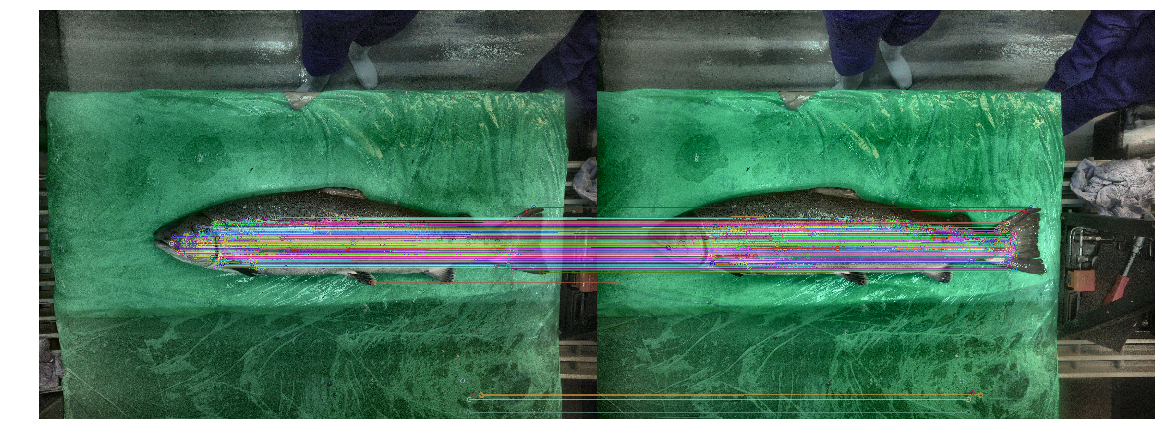

In [39]:
%matplotlib inline
idx = 0
left_image_f, _, _ = s3_access_utils.download_from_url(df.left_image_url.iloc[idx])
right_image_f, _, _ = s3_access_utils.download_from_url(df.right_image_url.iloc[idx])
imageL = cv2.imread(left_image_f)
imageR = cv2.imread(right_image_f)

MIN_MATCH_COUNT = 10
GOOD_PERC = 0.7

sift = cv2.KAZE_create()
img1 = enhance(imageL)
img2 = enhance(imageR)
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)


flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
    if m.distance < GOOD_PERC*n.distance:
        good.append(m)
if len(good)>=MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,7.0)
    matchesMask = mask.ravel().tolist()
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None
    
img3 = draw_matches(img1,kp1,img2,kp2,good,matchesMask,None,False)
img3o = draw_matches(img1,kp1,img2,kp2,good,matchesMask,None,True)
alpha = 0.7  # Transparency factor.
img3 = cv2.addWeighted(img3o, alpha, img3, 1 - alpha, 0)

f, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(img3)
ax.axis("off")
plt.show()

In [42]:
M.sum()

-593.551438545103

True

In [180]:
body_wkps = draw_matches_3D(img1, kp1, img2, kp2, good, matchesMask)

In [181]:
wkps = df.original_world_keypoints.iloc[idx]
wkps['BODY'] = np.array(body_wkps)
norm_wkps = _normalize_world_keypoints(wkps)


<IPython.core.display.Javascript object>


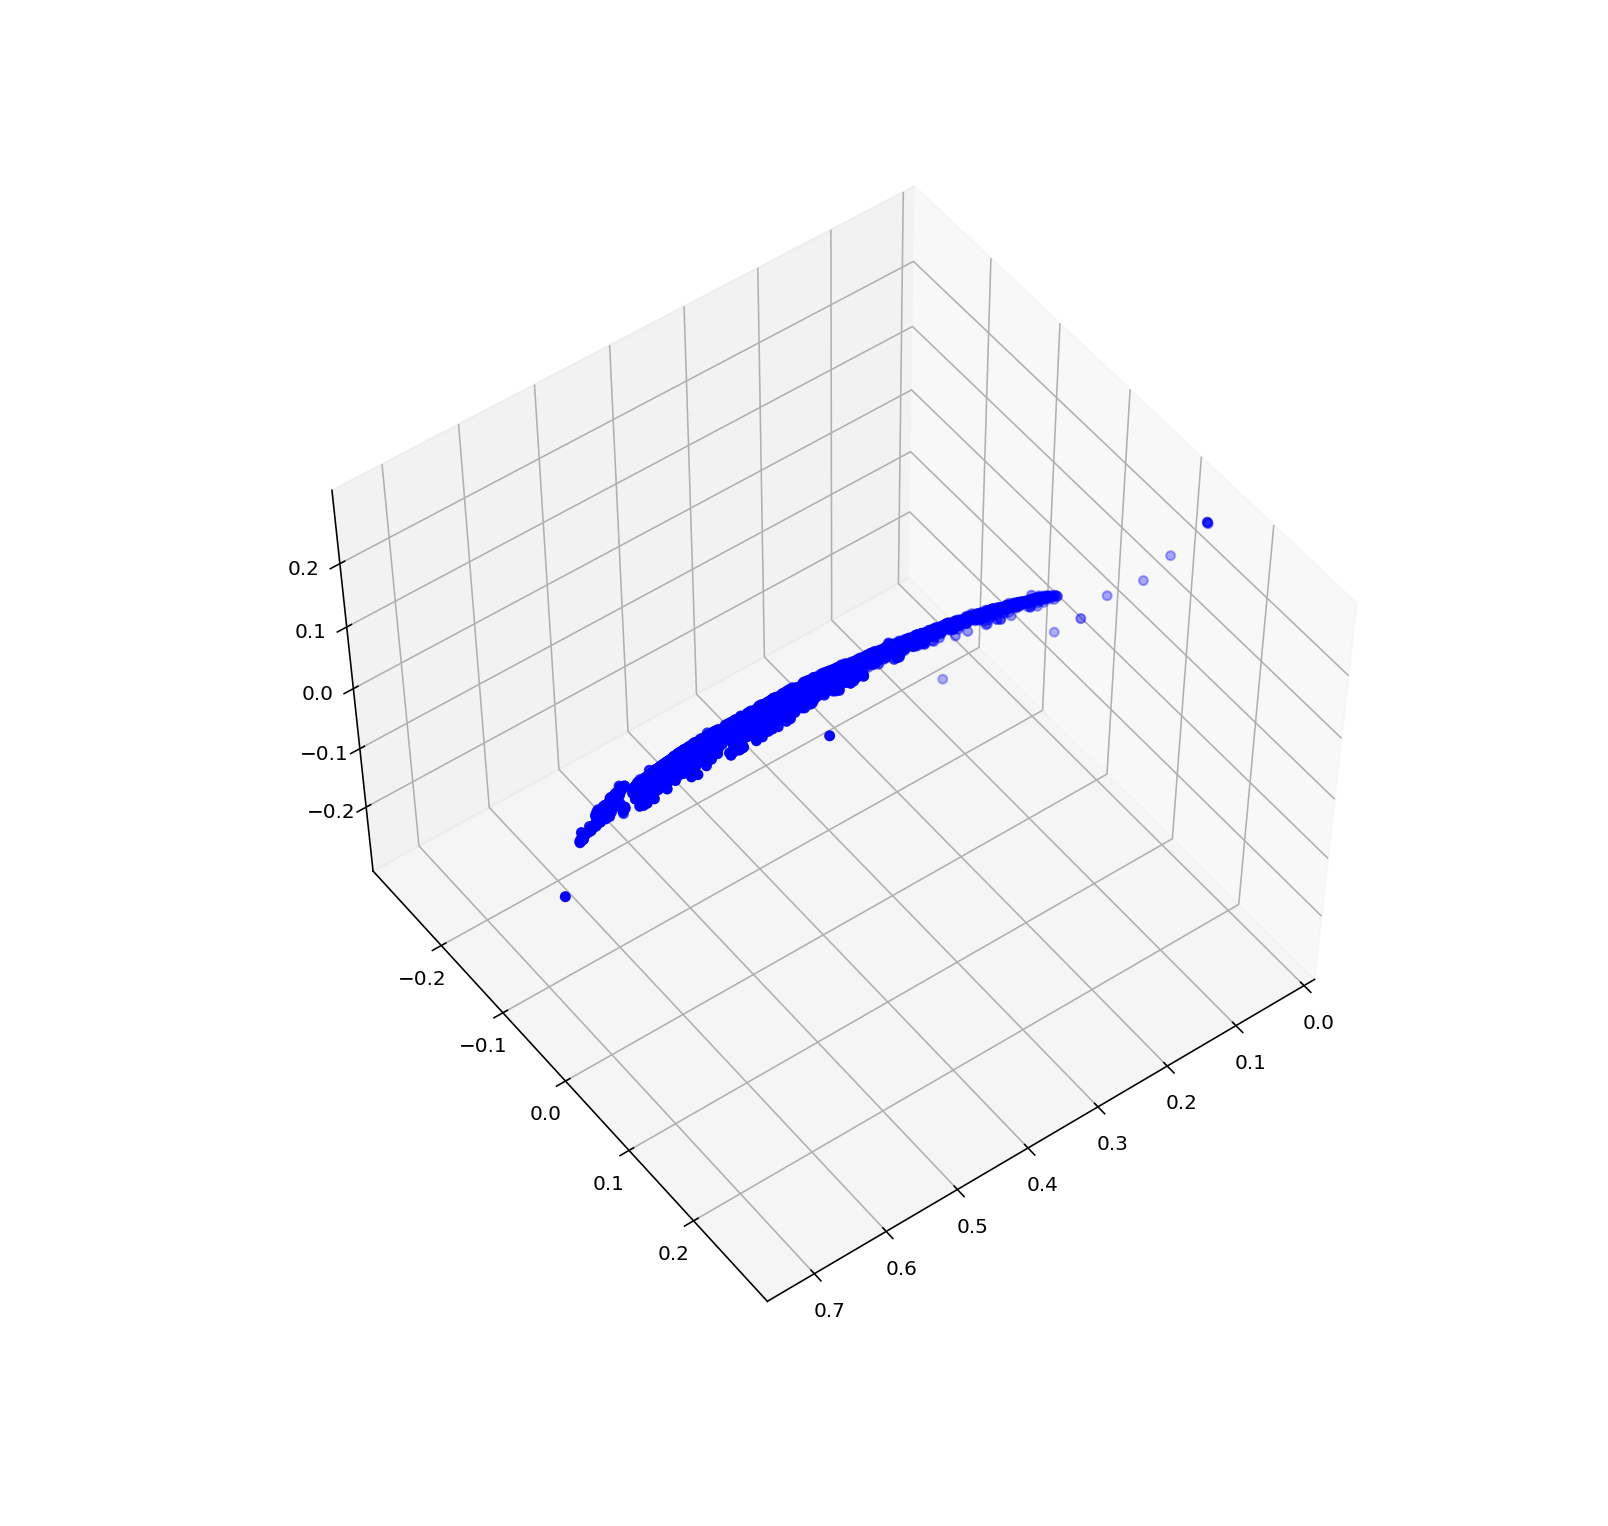

In [182]:
%matplotlib notebook
body_parts = [k for k in norm_wkps.keys() if k != 'BODY']
xs = [norm_wkps[bp][0] for bp in body_parts]
ys = [norm_wkps[bp][1] for bp in body_parts]
zs = [norm_wkps[bp][2] for bp in body_parts]
xs.extend(list(norm_wkps['BODY'][0]))
ys.extend(list(norm_wkps['BODY'][1]))
zs.extend(list(norm_wkps['BODY'][2]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, max(xs))
ax.set_ylim3d(-0.3, 0.3)
ax.set_zlim3d(-0.3, 0.3)
ax.scatter(xs, ys, zs, color='blue')

In [ ]:
df.data.apply(lambda x: x.get('breadthMms')) / 2.0

In [186]:
bdf[(bdf.captured_at >= '2019-09-06') & (bdf.captured_at < '2019-09-08')].fish_id.unique()

array(['190906-392e1f04-7eb4-4bb7-8a95-ae0a364c8fbb'], dtype=object)

<h1> Model Training </h1>

In [16]:
def generate_train_mask(df, train_frac, randomize=True):
    x = np.zeros((df.shape[0]), dtype=bool)
    x[:int(train_frac * df.shape[0])] = True
    np.random.shuffle(x)
    mask = pd.Series(x)
    return x
    

def generate_oos_score(features_df, mask, train_size, num_eigenvectors):
    np.random.seed(0)
    columns = pairwise_distance_columns + interaction_columns_quadratic + interaction_columns_cubic

    X_train = features_df.loc[mask, columns].values
    y_train = features_df.loc[mask, 'weight'].values
    w_train = features_df.loc[mask, 'w'].values
    X_test = features_df.loc[~mask, columns].values
    y_test = features_df.loc[~mask, 'weight'].values

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)

    pca = PCA(n_components=min(X_train_normalized.shape[0], X_train_normalized.shape[1]))
    pca.fit(X_train_normalized)
    explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
    idx = num_eigenvectors

    pca = PCA(n_components=idx+1)
    pca.fit(X_train_normalized)
    X_train_transformed = pca.transform(X_train_normalized)
    X_test_normalized = scaler.transform(X_test)
    X_test_transformed = pca.transform(X_test_normalized)

    reg = LinearRegression().fit(X_train_transformed, y_train, sample_weight=w_train)
    score = reg.score(X_test_transformed, y_test)

    y_pred = reg.predict(pca.transform(scaler.transform(features_df[columns].values)))
    features_df['prediction'] = y_pred
    features_df['error'] = features_df.prediction - features_df.weight
    features_df['error_pct'] = features_df.error / features_df.weight
    features_df['abs_error_pct'] = features_df.error_pct.abs()

    model = {
    'mean': scaler.mean_,
    'std': scaler.scale_,
    'PCA_components': pca.components_,
    'reg_coef': reg.coef_,
    'reg_intercept': reg.intercept_,
    'body_parts': body_parts_subset   
    }
    

    return mask, model, score



<h1> Plot one instance of train / test where the training set consists of 2000 fish </h1>

In [21]:
# num eigenvectors = 20

np.random.seed(0)
random.seed(0)
# tdf = features_df.copy(deep=True)

# weights = []
# i = 0
# for idx, row in tdf.iterrows():
#     if i % 100 == 0:
#         print(i)
#     i += 1
#     count = tdf[tdf.gtsf_fish_identifier == row.gtsf_fish_identifier].shape[0]
#     if count > 1:
#         weights.append(1.0 / count ** 0.5)
#     else:
#         weights.append(1)
        
# tdf['w'] = weights

gtsf_fish_identifiers = list(tdf.gtsf_fish_identifier.unique())
train_size = int(0.8 * len(gtsf_fish_identifiers))
fish_ids = random.sample(gtsf_fish_identifiers, train_size)
mask = tdf.gtsf_fish_identifier.isin(fish_ids) & (tdf.captured_at <= '2019-09-01')
mask, model, score = generate_oos_score(tdf, mask, 2000, 20)



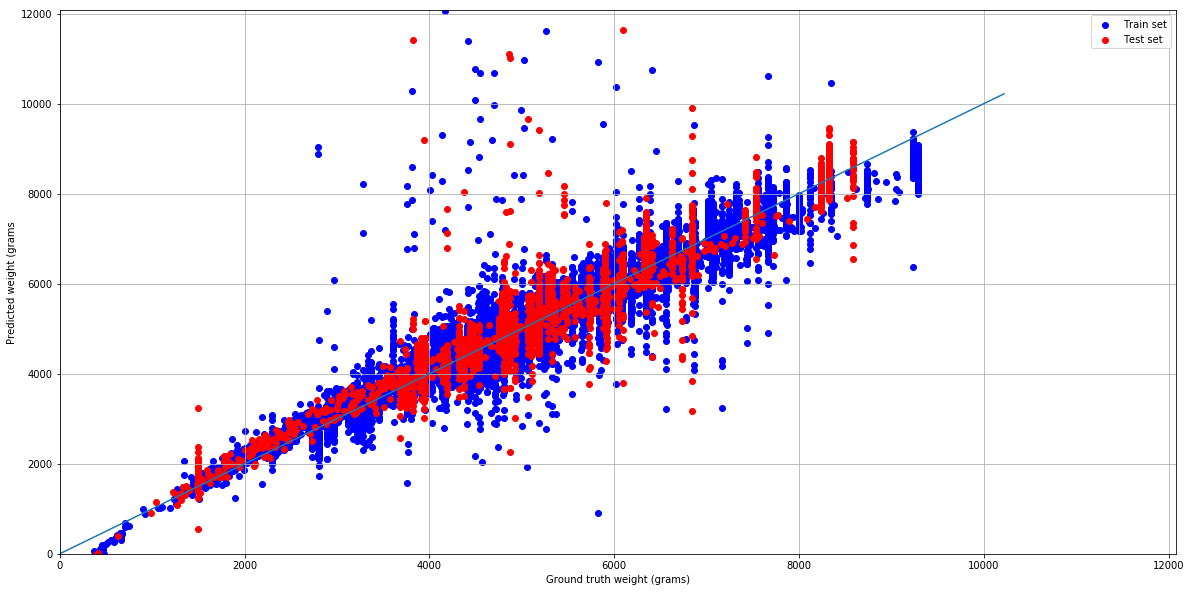

In [25]:
%matplotlib inline
amg = AccuracyMetricsGenerator()
test_mask = (~mask) & (tdf.captured_at <= '2019-09-01')
amg.set_data(mask, tdf.prediction.values, tdf.weight.values, w=tdf.w.values)
amg.plot_predictions_vs_ground_truth(impose_bounds=True)

In [48]:
amg = AccuracyMetricsGenerator()
amg.set_data(mask, tdf.prediction.values, tdf.weight.values, w=tdf.w.values)
amg.plot_predictions_vs_ground_truth(impose_bounds=True)

AttributeError: 'DataFrame' object has no attribute 'prediction'

In [42]:
tdf[tdf.error_pct > 0.5].keypoint_annotation_id

1151     714126
1161     714209
1588     720373
1633     720948
1816     725048
1825     725415
2132     606518
3423     719019
3451     719442
3493     720122
3517     720687
3526     721050
3546     721614
3573     722160
3618     723221
4539     648508
5293     718189
5409     720803
5422     721000
5436     721457
5568     724274
5588     724578
5589     724585
5602     724812
5927     606363
6131     635602
6895     714540
7156     717100
7247     718616
7279     719465
7281     719516
7381     721682
7393     722025
7448     723298
7491     724097
7524     724571
7758     507477
7864     606320
8188     638218
9031     717268
9068     717994
9076     718112
9187     720251
9197     720492
9218     720922
9235     721160
9237     721217
9442     648822
9982     636480
10171    640124
10242    709294
10972    717380
10975    717442
11097    720463
11109    720660
11111    720655
11160    721713
11206    722581
11275    724311
11594    613659
12472    712790
12825    717267
12845   

<h1> Visualize Individual Cases </h1>

In [95]:
s3_access_utils = S3AccessUtils('/root/data')
credentials = json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS']))
rds_access_utils = RDSAccessUtils(credentials)
v = Visualizer(s3_access_utils, rds_access_utils)


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/dialects/postgresql/base.py:3285: SAWarning: Skipped unsupported reflection of expression-based index frames_captured_at_date
  "expression-based index %s" % idx_name
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/dialects/postgresql/base.py:3285: SAWarning: Skipped unsupported reflection of expression-based index lati_fish_detections_detected_at_date
  "expression-based index %s" % idx_name


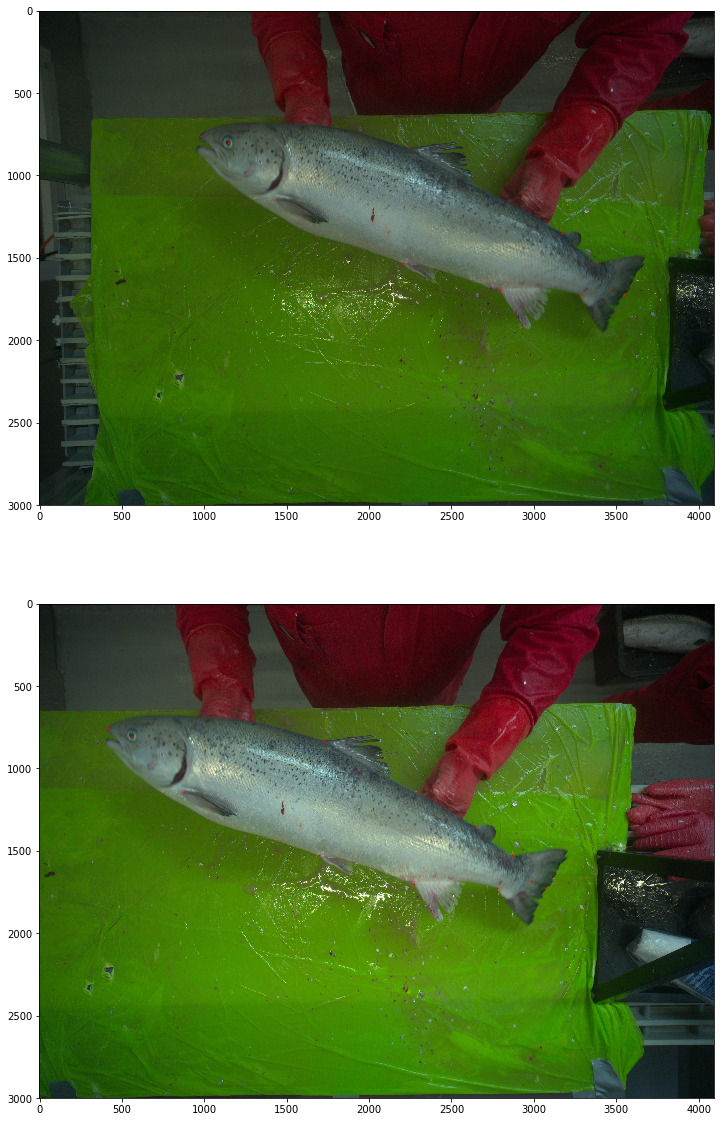

In [96]:
%matplotlib inline
keypoint_annotation_id = 724097
v.load_data(keypoint_annotation_id)
v.display_crops()

<IPython.core.display.Javascript object>


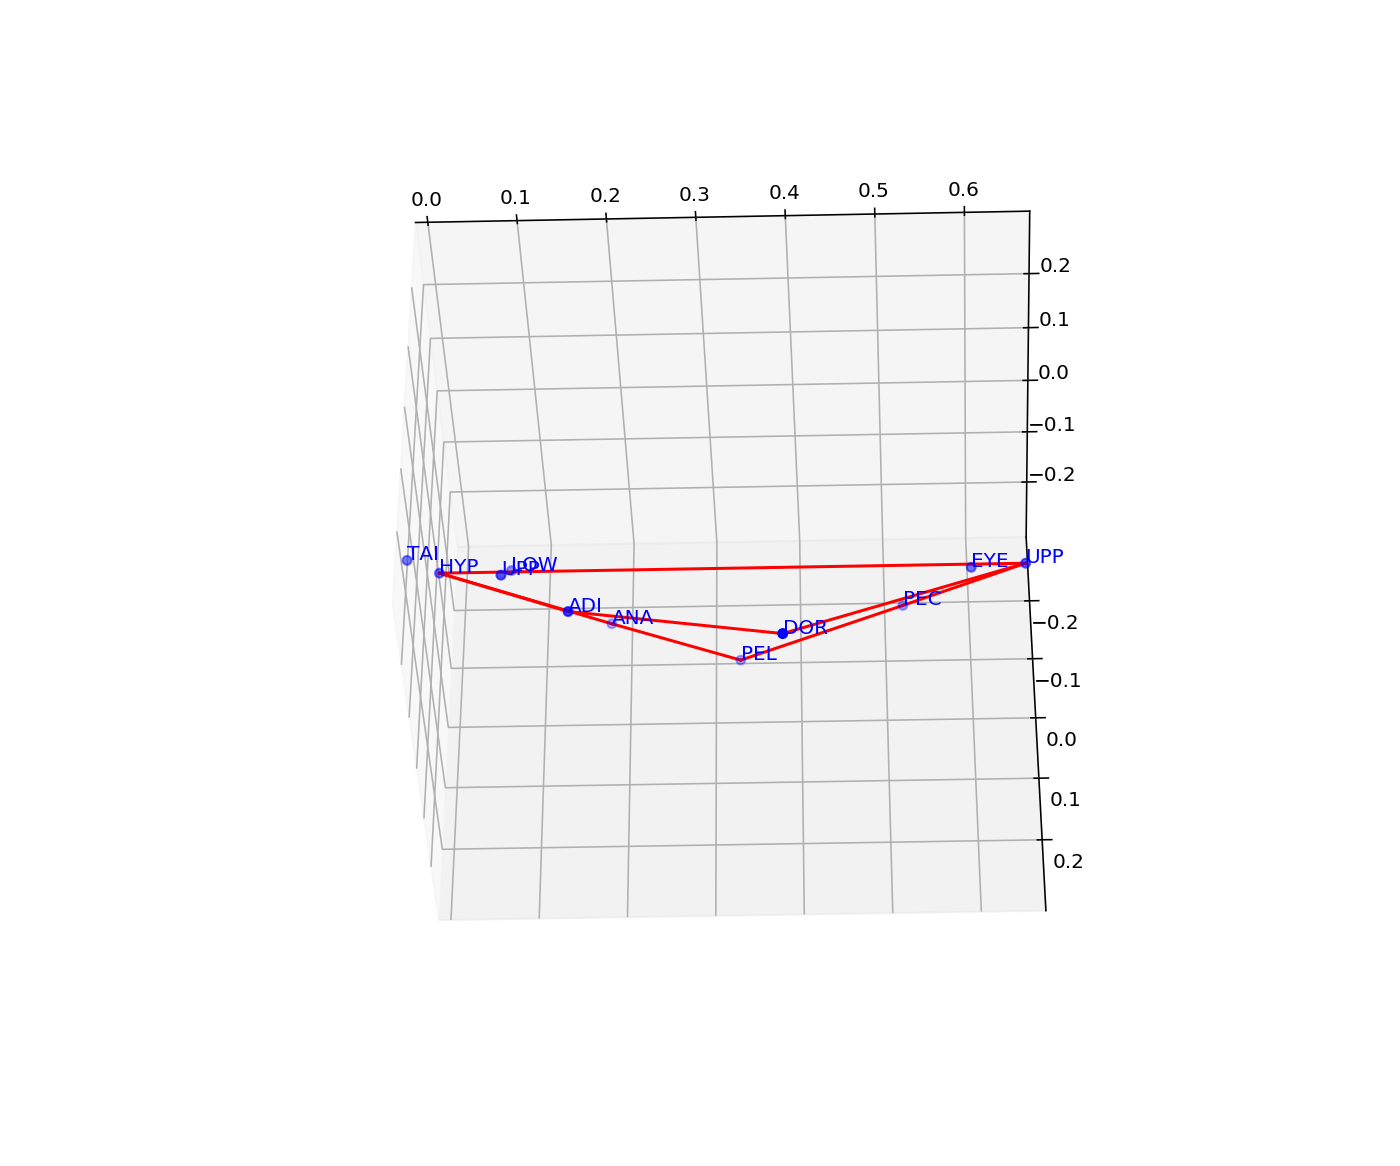

In [34]:
%matplotlib notebook
v.display_3d_keypoints()

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(features_df.rms_error_m, bins=100)
plt.grid()
plt.show()

In [ ]:
cm = plt.cm.get_cmap('seismic')
fig, ax = plt.subplots(figsize=(20, 10))
mask = features_df.rms_error_m < 0.5
sc = ax.scatter(features_df[mask].sort_values('rms_error_m').weight.values, 
            features_df[mask].sort_values('rms_error_m').prediction.values,
            c=features_df[mask].sort_values('rms_error_m').rms_error_m.values,
            cmap=cm)
plt.colorbar(sc)
plt.plot([0, 10000], [0, 10000])
# plt.xlim([0, 10000])
# plt.ylim([0, 10000])
plt.grid()
plt.show()

In [ ]:
features_df[mask].sort_values('error_pct', ascending=False).keypoint_annotation_id

In [36]:
def centroid_depth(wkps):
    if wkps:
        mean = np.mean(np.array([wkp[1] for wkp in wkps.values()]))
        if mean == np.inf:
            return None
        return mean
    return None

# features_df['centroid_depth'] = features_df.original_world_keypoints.apply(lambda x: centroid_depth(x))
bdf['centroid_depth'] = bdf.original_world_keypoints.apply(lambda x: centroid_depth(x))

In [ ]:
def calculated_depth(wkps):
    if wkps:
        mean = np.mean([wkps['DORSAL_FIN'], wkps['']])
        if mean == np.inf:
            return None
        return mean
    return None

features_df['centroid_depth'] = features_df.original_world_keypoints.apply(lambda x: centroid_depth(x))

In [ ]:
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.hist(features_df[(features_df.centroid_depth > 0) & (features_df.centroid_depth < 2.0)].centroid_depth, bins=100)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(features_df.centroid_depth, features_df.rms_error_m)
plt.grid()
plt.show()

In [ ]:
features_df.rms_error_m.mean()

In [ ]:
df.left_image_url.iloc[0]

In [114]:
cm = bdf[bdf.captured_at > '2019-09-01'].camera_metadata.iloc[-1]
x_upper_lip_left = 1016
y_upper_lip_left = 1051
x_upper_lip_right = 384
x_tail_notch_left = 3926
y_tail_notch_left = 1091
x_tail_notch_right = 3360
disp_upper_lip = abs(x_upper_lip_left - x_upper_lip_right)
disp_tail_notch = abs(x_tail_notch_left - x_tail_notch_right)
depth_upper_lip = depth_from_disp(disp_upper_lip, cm)
depth_tail_notch = depth_from_disp(disp_tail_notch, cm)
wkp_upper_lip = convert_to_world_point(x_upper_lip_left, y_upper_lip_left, depth_upper_lip, cm)
wkp_tail_notch = convert_to_world_point(x_tail_notch_left, y_tail_notch_left, depth_tail_notch, cm)
print(euclidean_distance(wkp_upper_lip, wkp_tail_notch))

0.6313054695011552


In [101]:
depth_upper_lip, depth_tail_notch

(0.5236831833397356, 0.5535014428893291)

In [32]:
df[df.captured_at >= '2019-09-01'].camera_metadata

Series([], Name: camera_metadata, dtype: object)

In [25]:
bdf['gt_length'] = bdf.data.apply(lambda x: x['lengthMms'] / 1e3)
bdf['pred_length'] = bdf.original_world_keypoints.apply(lambda x: euclidean_distance(x['UPPER_LIP'], x['TAIL_NOTCH']) if x else None)
bdf['length_diff'] = bdf.pred_length - bdf.gt_length

In [39]:
mask = (bdf.captured_at >= '2019-09-01') & (bdf.centroid_depth < 0.7)
bdf.loc[mask, ['length_diff', 'centroid_depth']]

length_diff  centroid_depth
1827     -0.053793        0.672812
1843      0.028198        0.513693
1846      0.018935        0.505513
1849      0.022616        0.521091
1852      0.022047        0.519951
1853      0.010684        0.484641
1856      0.023851        0.555123
1860      0.004809        0.495400
1861      0.015701        0.581798
1866      0.013364        0.487792
3766      0.026641        0.514635
3773      0.017325        0.524616
3781      0.023269        0.502222
3786      0.027589        0.524903
3787      0.016179        0.507261
3796      0.025491        0.516721
3805      0.013399        0.582912
3808      0.004802        0.489770
3809      0.017293        0.517889
3811      0.023564        0.513220
3814      0.001720        0.505929
3816      0.012505        0.509675
5732     -0.018319        0.659609
5736     -0.011218        0.619183
5748      0.020050        0.522513
5753      0.022050        0.515193
5759      0.022478        0.523965
5763      0.032147        0.510476
5765     -0.033230        0.588212
5769     -0.001091        0.503007
5773     -0.006378        0.489007
5776      0.033020        0.577067
5779      0.009481        0.492911
5781      0.021348        0.549398
7721      0.014389        0.511082
7722     -0.028275        0.698696
7726     -0.049003        0.655814
7731      0.025159        0.521546
7736      0.027650        0.508671
7738      0.010672        0.518220
7745      0.013437        0.513010
7746     -0.040638        0.518731
7750      0.026706        0.462202
7755     -0.031641        0.668576
7758      0.031063        0.534167
7759     -0.029468        0.540736
7761      0.004414        0.498075
7764     -0.008861        0.490349
9647      0.012668        0.504989
9653      0.029776        0.505451
9656      0.023228        0.499803
9660      0.028693        0.522673
9661      0.010316        0.519600
9663      0.025510        0.515930
9664      0.028404        0.504945
9673      0.034212        0.506281
9682      0.008807        0.547069
9687     -0.004223        0.506168
11606     0.010305        0.513163
11610    -0.041854        0.511547
11618     0.025293        0.516868
11620     0.021961        0.513658
11624    -0.045017        0.527450
11634     0.023598        0.518372
11643    -0.030116        0.537333
11648     0.013114        0.505208
13556     0.017973        0.513534
13557     0.024500        0.509988
13563     0.028406        0.516272
13565     0.028713        0.504729
13567     0.017668        0.493714
13576     0.024029        0.513144
13578     0.010844        0.597222
13592     0.015883        0.555001
15495     0.018488        0.514365
15503     0.017783        0.522657
15505    -0.046673        0.504878
15507     0.028624        0.512152
15509     0.024434        0.504733
15530     0.029198        0.499236

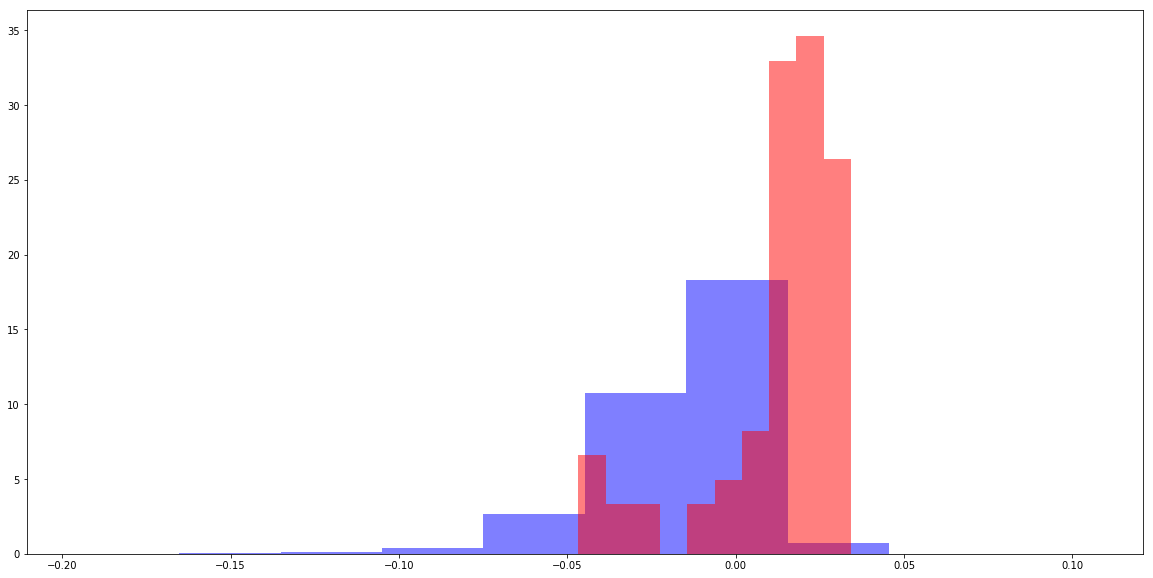

In [128]:
mask_1 = (bdf.captured_at <= '2019-09-10') & (bdf.centroid_depth < 0.7) & (bdf.length_diff.abs() < 0.2)
plt.figure(figsize=(20, 10))
plt.hist(bdf[mask_1].length_diff, bins=10, color='blue', alpha=0.5, density=True)
plt.grid()

mask_2 = (bdf.captured_at >= '2019-09-10') & (bdf.centroid_depth < 0.7) & (bdf.length_diff.abs() < 0.2)
plt.hist(bdf[mask_2].length_diff, bins=10, color='red', alpha=0.5, density=True)
plt.grid()
plt.show()


plt.show()

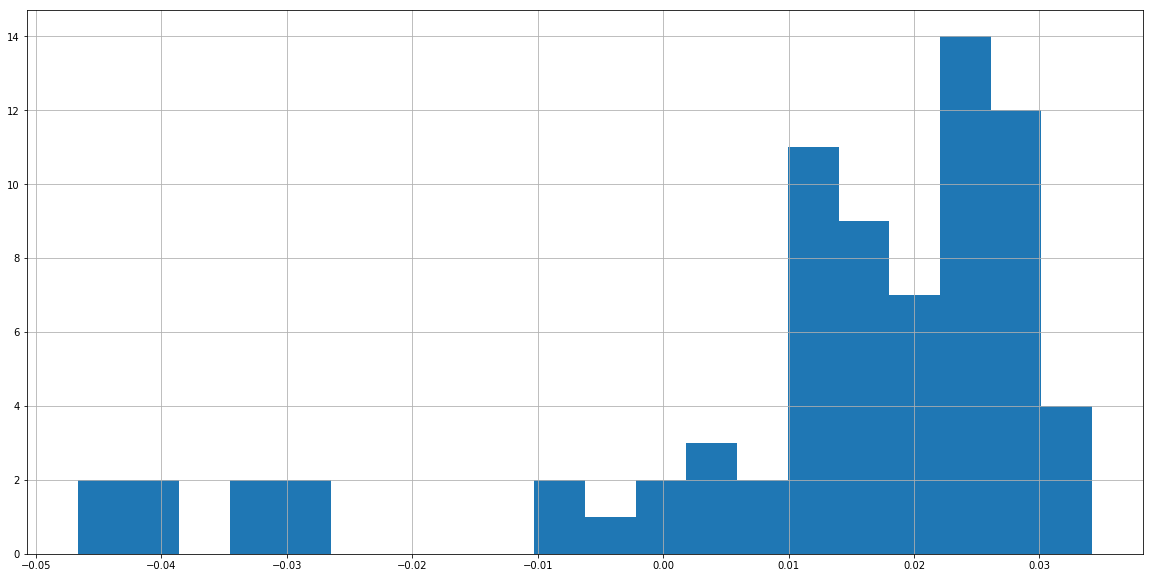

In [130]:
mask_2 = (bdf.captured_at >= '2019-09-10') & (bdf.centroid_depth < 0.7) & (bdf.length_diff.abs() < 0.2)
plt.figure(figsize=(20, 10))
plt.hist(bdf[mask_2].length_diff, bins=20)
plt.grid()
plt.show()

In [131]:
bdf[mask_2].sort_values('length_diff')

left_url  \
15505  http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190927-cbf969f9-eeaa-4240-aa6f-1feba840ad6f/date=2019-09-27/hour=12/at=2019-09-27T12:25:46.938323000Z/left_frame.jpg   
11624  http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190927-cbf969f9-eeaa-4240-aa6f-1feba840ad6f/date=2019-09-27/hour=12/at=2019-09-27T12:25:57.207317000Z/left_frame.jpg   
11610  http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190927-cbf969f9-eeaa-4240-aa6f-1feba840ad6f/date=2019-09-27/hour=12/at=2019-09-27T12:25:19.251781000Z/left_frame.jpg   
7746   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190927-cbf969f9-eeaa-4240-aa6f-1feba840ad6f/date=2019-09-27/hour=12/at=2019-09-27T12:26:05.418636000Z/left_frame.jpg   
5765   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-2b9cc63f-6f43-4a42-b1cf-b48e5e7d8467/date=2019-09-26/hour=09/at=2019-09-26T09:25:28.895551000Z/left_frame.jpg   
7755   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-2b9cc63f-6f43-4a42-b1cf-b48e5e7d8467/date=2019-09-26/hour=09/at=2019-09-26T09:26:08.937308000Z/left_frame.jpg   
11643  http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-2b9cc63f-6f43-4a42-b1cf-b48e5e7d8467/date=2019-09-26/hour=09/at=2019-09-26T09:27:33.085016000Z/left_frame.jpg   
7759   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-2b9cc63f-6f43-4a42-b1cf-b48e5e7d8467/date=2019-09-26/hour=09/at=2019-09-26T09:27:13.588279000Z/left_frame.jpg   
7764   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-9b2ce082-c14f-45a0-84d1-251ff4e38da0/date=2019-09-26/hour=12/at=2019-09-26T12:01:55.456545000Z/left_frame.jpg   
5773   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-79506bcc-d418-4184-a4da-2d81884907ab/date=2019-09-26/hour=11/at=2019-09-26T11:51:36.898453000Z/left_frame.jpg   
9687   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-9b2ce082-c14f-45a0-84d1-251ff4e38da0/date=2019-09-26/hour=12/at=2019-09-26T12:02:19.025125000Z/left_frame.jpg   
5769   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-9b2ce082-c14f-45a0-84d1-251ff4e38da0/date=2019-09-26/hour=12/at=2019-09-26T12:03:17.395528000Z/left_frame.jpg   
3814   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-cb1ea843-c372-408a-8679-8bc850112a12/date=2019-09-26/hour=09/at=2019-09-26T09:39:18.987957000Z/left_frame.jpg   
7761   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-9b2ce082-c14f-45a0-84d1-251ff4e38da0/date=2019-09-26/hour=12/at=2019-09-26T12:00:25.307599000Z/left_frame.jpg   
3808   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-9b2ce082-c14f-45a0-84d1-251ff4e38da0/date=2019-09-26/hour=12/at=2019-09-26T12:01:28.831207000Z/left_frame.jpg   
1860   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-2c6aea5a-b6ef-44dd-a114-0920d51e4064/date=2019-09-26/hour=11/at=2019-09-26T11:54:06.404373000Z/left_frame.jpg   
9682   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-cb1ea843-c372-408a-8679-8bc850112a12/date=2019-09-26/hour=09/at=2019-09-26T09:38:16.396572000Z/left_frame.jpg   
5779   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190926-79506bcc-d418-4184-a4da-2d81884907ab/date=2019-09-26/hour=11/at=2019-09-26T11:50:20.037370000Z/left_frame.jpg   
11606  http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190927-6364fe84-963e-4510-8cee-9111de13080a/date=2019-09-27/hour=12/at=2019-09-27T12:10:02.032749000Z/left_frame.jpg   
9661   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190927-6364fe84-963e-4510-8cee-9111de13080a/date=2019-09-27/hour=12/at=2019-09-27T12:15:37.552575000Z/left_frame.jpg   
7738   http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190927-2b5f56aa-e606-493b-8d49-3a5b714bcc7b/date=2019-0

In [136]:
bdf[mask_1 & (bdf.length_diff > 0.02)].sort_values('length_diff')

left_url  \
14672         http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-2c750417-6b12-4819-b93f-2790f4bdb7d4/date=2019-07-10/hour=06/at=2019-07-10T06:39:10.663559000Z/left_frame.jpg   
12528         http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-8bfd8c70-4398-474e-8873-ee91bbbe0f39/date=2019-07-10/hour=07/at=2019-07-10T07:59:34.310372000Z/left_frame.jpg   
15329         http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190730-43bb9967-298c-4ad4-8f1c-447e0911586c/date=2019-07-30/hour=08/at=2019-07-30T08:34:45.640818000Z/left_frame.jpg   
4523          http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190724-09ecb957-72ef-43dc-86d2-97e97d651960/date=2019-07-24/hour=08/at=2019-07-24T08:50:10.553375000Z/left_frame.jpg   
14555         http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-f1a56afc-326d-4c6c-8e2e-19e111d370f1/date=2019-07-10/hour=07/at=2019-07-10T07:43:11.423191000Z/left_frame.jpg   
1367          http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-8bfd8c70-4398-474e-8873-ee91bbbe0f39/date=2019-07-10/hour=07/at=2019-07-10T07:59:22.003483000Z/left_frame.jpg   
13899   https://s3-eu-west-1.amazonaws.com/aquabyte-crops/environment=research/site-id=35/pen-id=48/date=2019-03-05/hour=08/at=2019-03-05T08:45:19.441000000Z/left_frame_crop_654_1192_2994_1819.jpg   
10762         http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-8bfd8c70-4398-474e-8873-ee91bbbe0f39/date=2019-07-10/hour=08/at=2019-07-10T08:03:46.322000000Z/left_frame.jpg   
5216          http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-5ff011b3-fecc-4bb1-9c97-4f66b06426e1/date=2019-07-10/hour=11/at=2019-07-10T11:41:26.516784000Z/left_frame.jpg   
933           http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-eadbdd6b-6076-49f5-bef4-ded2806de31d/date=2019-07-10/hour=07/at=2019-07-10T07:38:12.905531000Z/left_frame.jpg   
1089          http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190718-5d5b9a64-2b3d-49bf-b3ba-85e580df8513/date=2019-07-18/hour=06/at=2019-07-18T06:51:39.446012000Z/left_frame.jpg   
8780          http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-8bfd8c70-4398-474e-8873-ee91bbbe0f39/date=2019-07-10/hour=07/at=2019-07-10T07:57:22.177066000Z/left_frame.jpg   
2592          http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190724-aa62007a-31ca-4d8c-bf42-f277b8e40f48/date=2019-07-24/hour=08/at=2019-07-24T08:41:30.889216000Z/left_frame.jpg   
14755         http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-8bfd8c70-4398-474e-8873-ee91bbbe0f39/date=2019-07-10/hour=07/at=2019-07-10T07:57:05.763452000Z/left_frame.jpg   
11831    https://s3-eu-west-1.amazonaws.com/aquabyte-crops/environment=research/site-id=35/pen-id=48/date=2019-05-29/hour=11/at=2019-05-29T11:47:14.757000000Z/left_frame_crop_894_899_3554_1678.jpg   
2756          http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-8bfd8c70-4398-474e-8873-ee91bbbe0f39/date=2019-07-10/hour=07/at=2019-07-10T07:59:27.136849000Z/left_frame.jpg   
8626          http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-8bfd8c70-4398-474e-8873-ee91bbbe0f39/date=2019-07-10/hour=08/at=2019-07-10T08:02:33.585290000Z/left_frame.jpg   
8621          http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190710-8bfd8c70-4398-474e-8873-ee91bbbe0f39/date=2019-07-10/hour=08/at=2019-07-10T08:02:09.000527000Z/left_frame.jpg   
9810    https://s3-eu-west-1.amazonaws.com/aquabyte-crops/environment=research/site-id=35/pen-id=48/date=2019-05-09/hour=08/at=2019-05-09T08:59:38.277000000Z/left_frame_crop_1094_735_3330_1403.jpg   
11498         http://aquabyte-axiom-rectified.s3.eu-west-1.amazonaws.com/fishId=190730-566ac7f4-fe72-4f0f-bf2f-80a718aabbdf/date=2019-07-30/hour=10/at=2019-07-30T10:57:47.328927000Z/left_f

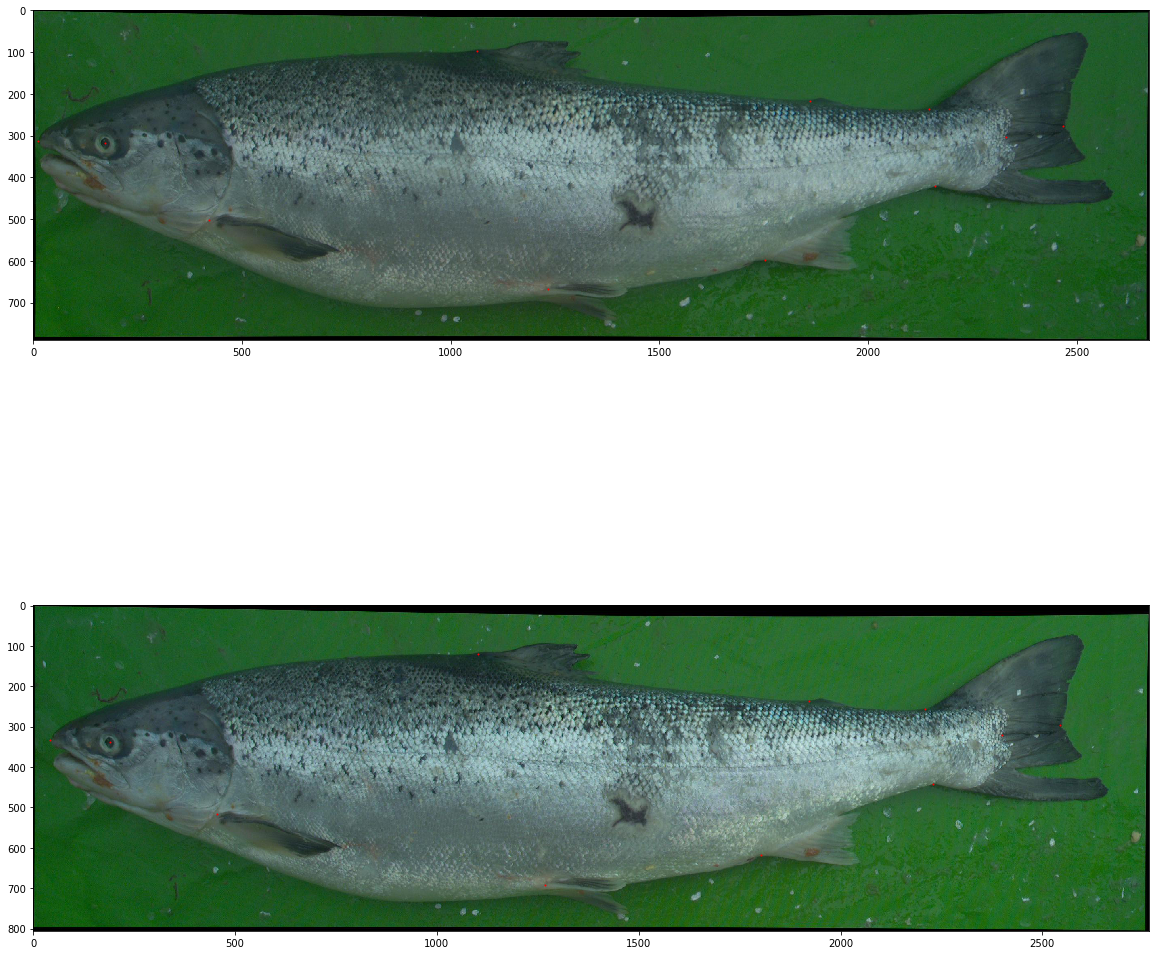

In [142]:
%matplotlib inline
keypoint_annotation_id = 507364
v.load_data(keypoint_annotation_id)
v.display_crops()